# import + functions

import os

In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt  
import json

def make_transition_df(df):
    transitions = []
    in_in_Latency = []
    for index in range(len(df.Port.values)):
        if index < len(df.Port.values)-1:
            transit = int(str(df.Port.values[index]) + str(df.Port.values[index+1]))
            transitions += [transit]
            in_in_diff = df.PokeIn_Time.values[index+1] - df.PokeIn_Time.values[index]
            in_in_Latency += [in_in_diff]
        
 
    transit_df = pd.DataFrame({'Trial_id': df.Trial_id.values[0:-1], 
                                'Transition_type': transitions,
                                'in_in_Latency': in_in_Latency,
                                '2s_Time_Filter_in_in': list((np.array(in_in_Latency) <= 2).astype(int))})
    return transit_df

def get_mean_port_port_transition_latencies(day1_path):
    raw_poke_path = os.path.join(day1_path, np.array(os.listdir(day1_path))[['.csv' in file for file in os.listdir(day1_path)]][0])
    raw_pokes = pd.read_csv(raw_poke_path)
    raw_transits = make_transition_df(raw_pokes)
    mean_port_port_transition_latencies = np.mean(raw_transits['in_in_Latency'].values)
    return mean_port_port_transition_latencies

# main

In [2]:
# pull in the data and calculate deltas
data_path = r"Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\"

replay_type = 'sequential_NREM_and_REM_sleep'


In [3]:
# create dfs to hold the data
predictor_matrix_general_df = pd.DataFrame()
predictor_matrix_motif_df = pd.DataFrame()
outcome_matrix_general_df = pd.DataFrame()
outcome_matrix_motif_df = pd.DataFrame()

for mir in os.listdir(data_path):
    Tracking = False
    Pokes1 = False
    Pokes2 = False
    
    current_path = os.path.join(data_path, mir)
    # only bother loading any of the data if there is replay data saved out. 
    if 'replay' in os.listdir(current_path):#
        print('-------------------------------')
        print(f"Processing {mir}")
        replay_path = os.path.join(current_path, 'replay',replay_type)
        # load replay json 
        json_path = replay_path + r'\replay_data_variables.json'
        with open(json_path, 'r') as file:
            replay_data = json.load(file)
            print(f"Loaded replay data for {mir} from {json_path} ✓ ")
            
        # load in beahvioural data
        for file in os.listdir(current_path):
            if 'day2' in file:
                day2_path = os.path.join(current_path, file)
                # i forgot to do this in the preprocessing, so i added it in here 
                mean_port_port_transition_latencies_2 = get_mean_port_port_transition_latencies(day2_path)
                if 'processed' in os.listdir(day2_path):
                    processed_poke_data_2 = pd.read_csv(os.path.join(day2_path, 'processed', 'processed_poke_data_2.csv'))
                    processed_poke_data_2['transition_times'] = mean_port_port_transition_latencies_2
                    print(f"Loaded poke data 2 for {day2_path} ✓ ")
                    Pokes2 = True
                    try:
                        processed_tracking_data_2 = pd.read_csv(os.path.join(day2_path, 'processed', 'processed_tracking_data.csv'))
                        Tracking = True
                        print(f"Tracking data 2 found for {day2_path} ✓ ")
                    except:
                        print(f"Tracking data not found for {day2_path} ✗")
                        Tracking = False
        for file in os.listdir(current_path):
            if 'day1' in file:
                day1_path = os.path.join(current_path, file)
                # i forgot to do this in the preprocessing, so i added it in here 
                mean_port_port_transition_latencies_1 = get_mean_port_port_transition_latencies(day1_path)
                if 'processed' in os.listdir(day1_path):
                    processed_poke_data_1 = pd.read_csv(os.path.join(day1_path, 'processed', 'processed_poke_data_1.csv'))
                    processed_poke_data_1['transition_times'] = mean_port_port_transition_latencies_1
                    Pokes1 = True
                    print(f"Loaded poke data 1 for {day1_path} ✓ ")
                    try:
                        processed_tracking_data_1 = pd.read_csv(os.path.join(day1_path, 'processed', 'processed_tracking_data.csv'))
                        Tracking = True
                        print(f"Tracking data 1 found for {day1_path} ✓ ")
                    except:
                        print(f"Tracking data not found for {day1_path} ✗")
                        Tracking = False
                        
        if Pokes1 * Pokes2 == True:
            #### Add replay data (predictor) to dataframes
            
            # add all the data to dataframes
            predictor_general_dict = {}
            predictor_general_dict['animal_id'] = mir
            for key, val in replay_data.items():
                if 'motif' not in key:
                    mean_val = np.mean(val) if np.ndim(val) > 0 else val
                    predictor_general_dict.setdefault(key, []).append(mean_val)
                    
            if Tracking:
                predictor_motif_dict = {}
                for key, val in replay_data.items():
                    predictor_motif_dict['animal_id'] = [mir] * len(replay_data['motif_event_rpm'])
                    if 'motif' in key:
                        if np.ndim(replay_data[key][0]) > 0:
                            vals = [np.nanmean(value) for value in replay_data[key]]
                        else:
                            vals = val
                        predictor_motif_dict[key] = vals
                
            #concatenate to DataFrame
            predictor_matrix_general_df = pd.concat([predictor_matrix_general_df, pd.DataFrame(predictor_general_dict)], ignore_index=True)
            if Tracking:
                
                # only keep df rows which appear in the task_relevant_sequences
                task_relevant_sequences = processed_tracking_data_1.sequence_motif.values - 1 
                current_predictor_matrix = pd.DataFrame(predictor_motif_dict)
                current_predictor_matrix = current_predictor_matrix[current_predictor_matrix.index.isin(task_relevant_sequences)]
                current_predictor_matrix['sequence_motif'] = sorted(task_relevant_sequences)
                predictor_matrix_motif_df = pd.concat([predictor_matrix_motif_df, current_predictor_matrix], ignore_index=True)


            #################
            ## calculate behvaioural deltas
            delta_behavioural_data = processed_poke_data_2 - processed_poke_data_1
            if Tracking:
                delta_tracking_data = processed_tracking_data_2 - processed_tracking_data_1
                
            delta_behavioural_data['mouse_id'] = mir
            if Tracking:
                delta_tracking_data['mouse_id'] = [mir] * len(delta_tracking_data)   
                
            # add deltas to dataframes
            outcome_matrix_general_df = pd.concat([outcome_matrix_general_df, delta_behavioural_data], ignore_index=True)
            if Tracking:
                outcome_matrix_motif_df = pd.concat([outcome_matrix_motif_df, delta_tracking_data], ignore_index=True)

 




-------------------------------
Processing EJT136_1_3
Loaded replay data for EJT136_1_3 from Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\EJT136_1_3\replay\sequential_NREM_and_REM_sleep\replay_data_variables.json ✓ 
Loaded poke data 2 for Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\EJT136_1_3\day2_12-11-2021 ✓ 
Tracking data 2 found for Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\EJT136_1_3\day2_12-11-2021 ✓ 
Loaded poke data 1 for Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\EJT136_1_3\day1_11-11-2021 ✓ 
Tracking data 1 found for Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\EJT136_1_3\day1_11-11-2021 ✓ 
-------------------------------
Processing EJT136_1_4
Loaded replay data for EJT136_1_4 from Z:\projects\sequen

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_49764\1220364679.py:77: RuntimeWarning: Mean of empty slice
  vals = [np.nanmean(value) for value in replay_data[key]]


Loaded replay data for EJT269_1_4 from Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\EJT269_1_4\replay\sequential_NREM_and_REM_sleep\replay_data_variables.json ✓ 
Loaded poke data 2 for Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\EJT269_1_4\day2_19-05-2023 ✓ 
Tracking data 2 found for Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\EJT269_1_4\day2_19-05-2023 ✓ 
Loaded poke data 1 for Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\EJT269_1_4\day1_18-05-2023 ✓ 
Tracking data 1 found for Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_link_data\replay_to_behaviour\\EJT269_1_4\day1_18-05-2023 ✓ 
-------------------------------
Processing EJT270_1_6
Loaded replay data for EJT270_1_6 from Z:\projects\sequence_squad\revision_data\emmett_revisions\sleep_wake_lin

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_49764\1220364679.py:77: RuntimeWarning: Mean of empty slice
  vals = [np.nanmean(value) for value in replay_data[key]]



# CCA - canonical correlation analysis
like PCA but instead of finding reduced dimensions that best describe the variance in the data it compresses the data onto two dimesnions that maximally correlate (one dimension each). You can then look at how each feature weights to each dimensions

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import CCA
from scipy.stats import pearsonr
import numpy as np

def stadardise_data(X, Y):
    """
    Standardizes the input data X and Y.
    """
    X_scaled = StandardScaler().fit_transform(X)
    Y_scaled = StandardScaler().fit_transform(Y)
    return X_scaled, Y_scaled

from sklearn.linear_model import LinearRegression

def plot_canonical_variates(X_c, Y_c):
    """
    Plots the canonical variates.
    """
    fig, ax = plt.subplots(1, 4, figsize=(20, 5))
    for i in range(4):
        # Correlation between canonical variates
        r, _ = pearsonr(X_c[:, i], Y_c[:, i])
        print(f"Canonical correlation (component {i+1}): {r:.3f}")
        # Plot the canonical variates
        ax[i].scatter(X_c[:, i], Y_c[:, i])
        ax[i].set_xlabel('Behaviour (Canonical)')
        ax[i].set_ylabel('Replay (Canonical)')
        ax[i].set_title(f'r = {r:.2f} component {i+1}')
        
        # Fit regression model
        model = LinearRegression()
        model.fit(X_c[:, i].reshape(-1, 1), Y_c[:, i].reshape(-1, 1))

        # Predict y values
        y_pred = model.predict(X_c[:, i].reshape(-1, 1))

        ax[i].plot(X_c[:, i], y_pred, color='pink', label="Regression line")
                



In [12]:
list(outcome_matrix_motif_df)

['sequence_motif',
 'mean_h_distance_from_av_mm',
 'std_h_distance_from_av_mm',
 'mean_dtw_distance_from_av_mm',
 'std_dtw_distance_from_av_mm',
 'mean_movement_speed_mm_s',
 'std_movement_speed_mm_s',
 'mouse_id']

In [ ]:


#SLEEP BEHAVIOUR LINK

# replay features:

# motif rate per min 
# motif relative event rate 
# motif relative proportion 
# motif spikes per event
# motif units per event
# motif event lengths
# motif proportion coactive
# motif proportion appearing in ordered coative pairs
# motif overall neuron spiking consistency - are the neurons that we saw in replay on average consistently in or not in awake replay?
# motif average warp factor
# motif forward vs reverse replay ratio 
# motif proportion spindle linked / distance to closest spindle 

# behavioural features:

# motif mean variability (av. distance from average)
# motif std variability (std of distance from average)
# motif average movement speed
# motif movement speed variability (standard deviation) 
# training level change in that session
# motif error rate (take the closest two ports and see what the error rate was there?)
# reward per motif ratio (how many rewards were given per motif) 
# average distance (seconds) to next reward
# # motif spike consistency (in awake sequences, how consistent were the neurons in the replay sequences?)





chose data and run CCA

C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_49764\3750615638.py:40: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  'std_h_distance_from_av_mm']).applymap(lambda x: 0 if isinstance(x, str) or pd.isna(x) else x)
C:\Users\Emmett Thompson\AppData\Local\Temp\ipykernel_49764\3750615638.py:49: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X= X_df.applymap(lambda x: 0 if isinstance(x, str) or pd.isna(x) else x)


Canonical correlation (component 1): 0.661
Canonical correlation (component 2): 0.365
Canonical correlation (component 3): 0.222
Canonical correlation (component 4): 0.068


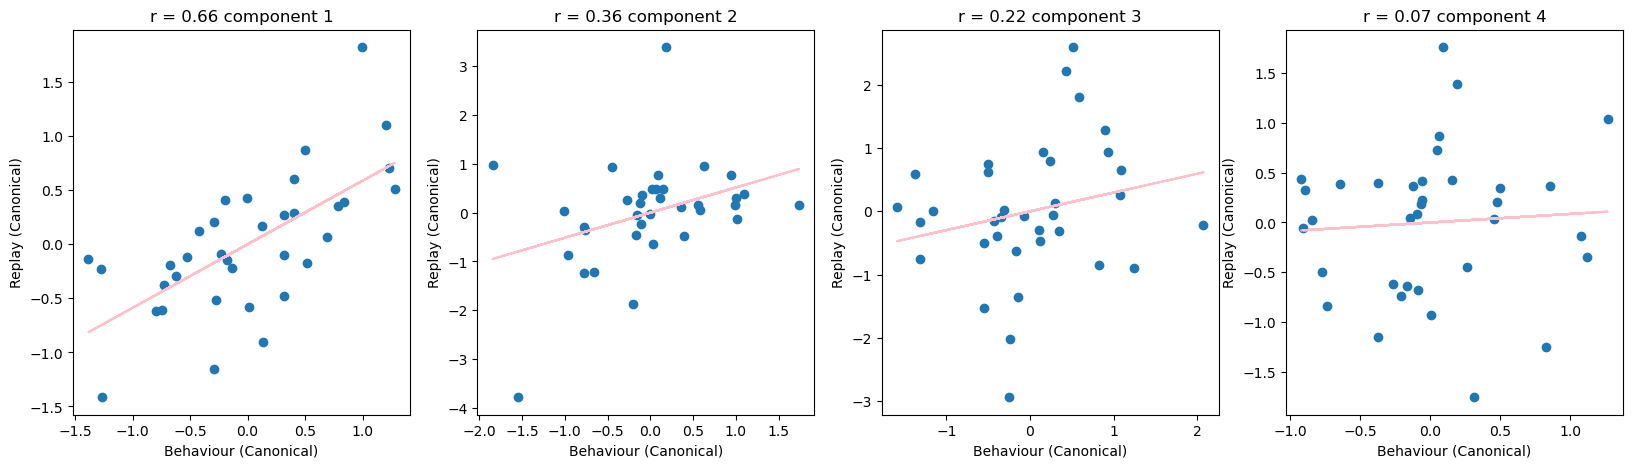

In [ ]:


######## set up MOTIF data for CCA ########

X_array = predictor_matrix_motif_df # shape: (n_samples, n_features)
Y = outcome_matrix_motif_df.drop(columns=['mouse_id','sequence_motif','mean_h_distance_from_av_mm',
'std_h_distance_from_av_mm']).applymap(lambda x: 0 if isinstance(x, str) or pd.isna(x) else x)

# drop some more complex predictor comunns 
X_df = X_array.drop(columns = ['animal_id',
'motif_proportion_coactive',
'motif_meaned_ordering_ordered_prop_out_of_all_task_related',
'motif_fs_ordering_ordered_prop_out_of_all_task_related',
'sequence_motif'])

X= X_df.applymap(lambda x: 0 if isinstance(x, str) or pd.isna(x) else x)

################# RUN CCA Analysis #################
# Standardize
X_scaled, Y_scaled = stadardise_data(X, Y)
# CCA
cca = CCA(n_components=4)
X_c, Y_c = cca.fit_transform(X_scaled, Y_scaled)
# Plot canonical variates
plot_canonical_variates(X_c, Y_c)





permutation test for each component

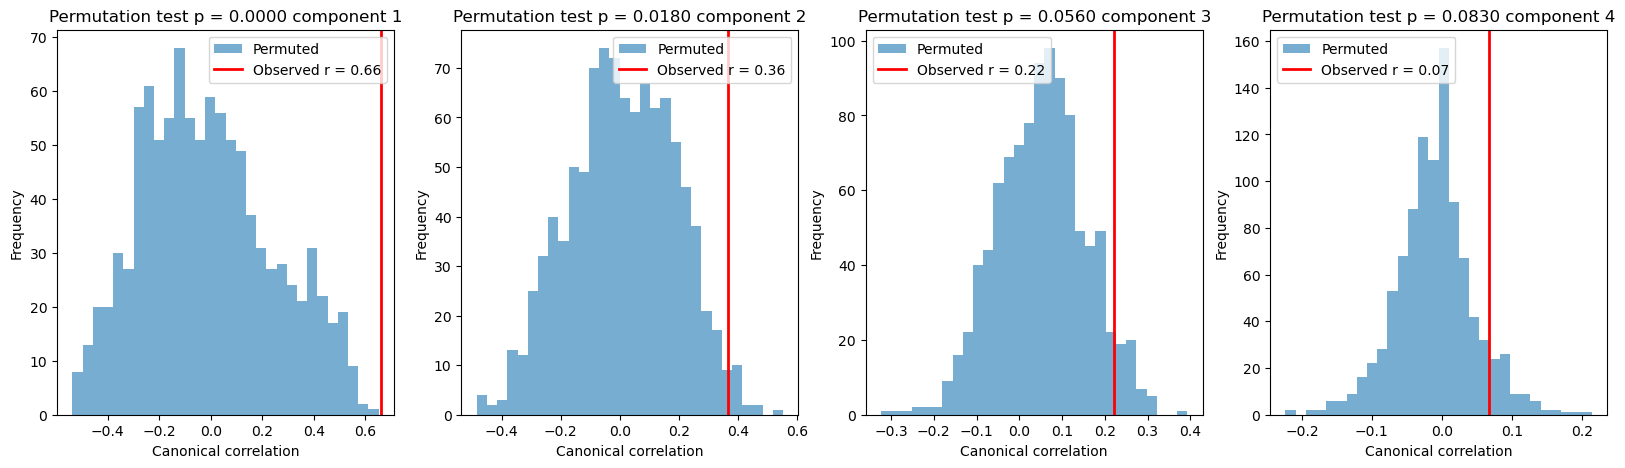

In [8]:
n_perms = 1000
fig, ax = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):

    perm_r = []
    for _ in range(n_perms):
        Y_perm = np.random.permutation(Y_scaled)
        _, Y_c_perm = cca.fit_transform(X_scaled, Y_perm)
        r_perm, _ = pearsonr(X_c[:, i], Y_c_perm[:, i])
        perm_r.append(r_perm)

    # True correlation
    X_c, Y_c = cca.fit_transform(X_scaled, Y_scaled)
    
    r_true, _ = pearsonr(X_c[:, i], Y_c[:, i])

    p_val = np.mean(np.array(perm_r) >= r_true)


    ax[i].hist(perm_r, bins=30, alpha=0.6, label='Permuted')
    ax[i].axvline(r_true, color='red', linewidth=2, label=f'Observed r = {r_true:.2f}')
    ax[i].set_xlabel("Canonical correlation")
    ax[i].set_ylabel("Frequency")
    ax[i].set_title(f"Permutation test p = {p_val:.4f} component {i+1}")
    ax[i].legend()


extract the feature weights and bootstrap the data to get error bars

In [9]:
# --- Step 1: Standardize ---
X_scaled = StandardScaler().fit_transform(X)
Y_scaled = StandardScaler().fit_transform(Y)

# --- Step 2: Fit CCA on full data ---
cca = CCA(n_components=1)
X_c, Y_c = cca.fit_transform(X_scaled, Y_scaled)
x_weights = cca.x_weights_[:, 0]
y_weights = cca.y_weights_[:, 0]

# --- Step 3: Bootstrap ---
n_boots = 1000
x_weights_all = np.zeros((n_boots, X.shape[1]))
y_weights_all = np.zeros((n_boots, Y.shape[1]))

for i in range(n_boots):
    idx = np.random.choice(len(X), size=len(X), replace=True)
    X_boot = X_scaled[idx]
    Y_boot = Y_scaled[idx]
    
    cca.fit(X_boot, Y_boot)
    x_weights_all[i] = cca.x_weights_[:, 0]
    y_weights_all[i] = cca.y_weights_[:, 0]

# --- Step 4: Compute 95% confidence intervals ---
x_mean = x_weights_all.mean(axis=0)
y_mean = y_weights_all.mean(axis=0)

x_err = scipy.stats.sem(x_weights_all, axis=0)
y_err = scipy.stats.sem(y_weights_all, axis=0)

# Sort by absolute weight magnitude
sorted_idx_x = np.argsort(-np.abs(x_mean))
sorted_idx_y = np.argsort(-np.abs(y_mean))

# Behaviour
beh_names = np.array(X.columns)[sorted_idx_x]
beh_vals = x_mean[sorted_idx_x]

# Replay
rep_names = np.array(Y.columns)[sorted_idx_y]
rep_vals = y_mean[sorted_idx_y]

# Plot
fig, axes = plt.subplots(1, 2, figsize=(10, max(len(X.columns), len(Y.columns)) * 0.3), sharey=True)

axes[0].barh(beh_names, beh_vals, xerr= x_err, color='steelblue', alpha=0.8)
axes[0].set_title('Canonical Weights (95% CI) – Behaviour')
axes[0].axvline(0, color='black', linewidth=0.8)

axes[1].barh(rep_names, rep_vals, xerr=y_err, color='darkorange', alpha=0.8)
axes[1].set_title('Canonical Weights (95% CI) – Replay')
axes[1].axvline(0, color='black', linewidth=0.8)


NameError: name 'scipy' is not defined